***PART 1: Basic model selection with k-Nearest Neighbors***

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.datasets as ds
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
from scipy import stats

from pandas.core.frame import DataFrame
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
pd.set_option('display.max_rows', 4000)
pd.set_option('display.max_columns', 4000)

In [ ]:
train_df = pd.read_csv('train_df_prepared.csv', sep=',')
test_df = pd.read_csv('test_df_prepared.csv', sep=',')

In [ ]:
# Task: Create a temporary DataFrame containing only PCR_04 and PCR_09.
# Reminder: Use the preprocessed (normalized) training set.
temp_df = train_df[['PCR_04', 'PCR_09']]

In [ ]:
##################################################################
def visualize_clf(clf, X, Y, title, 
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap
    
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
        
    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)
    
    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()
   

In [ ]:
# (Q1)  Train  a  k-NN  model  using  𝑘 = 1  on  your  training  set  and  use  the  visualize_clf 
# method to visualize the resulted decision regions (with appropriate title and labels).
Knn = KNeighborsClassifier(n_neighbors=1)
Knn.fit(temp_df, train_df['spread'])
visualize_clf(Knn, temp_df, train_df['spread'], 'k-NN (k=1)', 'PCR_04', 'PCR_09')

In [ ]:
from sklearn.model_selection import cross_validate

# (Q2) Use sklearn.model_selection.cross_validate to find the best 𝑘 (neighbors) value in
# list(range(1, 20, 2)) + list(range(20, 695, 65)) for predicting the spread class
# using PCR_04 and PCR_09. Read the API carefully to understand how to extract train
# scores.
# Use the (default) accuracy metric and 8-folds to perform cross-validation.
# Using the outputs of cross_validate, plot a validation curve, i.e., the (mean) training
# and validation accuracies (y-axis) as functions of the 𝑘 values (x-axis). Make the x-axis
# logarithmic (using plt.semilogx) and attach the plot (with the 2 curves) to your report.

import matplotlib.pyplot as plt

# Define the range of k values
k_values = list(range(1, 20, 2)) + list(range(20, 695, 65))

# Initialize lists to store mean training and validation accuracies
train_scores = []
val_scores = []

# Perform cross-validation for each k value
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, temp_df, train_df['spread'], cv=8, return_train_score=True)
    train_scores.append(scores['train_score'].mean()* 100.0)
    val_scores.append(scores['test_score'].mean() * 100.0)


# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.semilogx(k_values, train_scores, label='Training Accuracy')
plt.semilogx(k_values, val_scores, label='Validation Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Validation Curve')
plt.legend()
plt.show()

# print optimal k value
k_optimal = k_values[np.argmax(val_scores)]
print(f'Optimal k value: {k_optimal} with training accuracy: {train_scores[np.argmax(val_scores)] :.2f}%')
print(f'Validation accuracy: {max(val_scores):.2f}%')

In [ ]:
# (Q3) Use the optimal 𝑘 value you found and retrain a k-NN model on all the training samples.
# In your report: plot the decision regions of this final model (using visualize_clf)
# and write its test accuracy (computed on the separate test split) of this model.

# Retrain the k-NN model using the optimal k value
Knn_optimal = KNeighborsClassifier(n_neighbors=k_optimal)
Knn_optimal.fit(temp_df, train_df['spread'])


# plot the decision regions of this final model (using visualize_clf)
visualize_clf(Knn_optimal, temp_df, train_df['spread'], 'k-NN (k=13)', 'PCR_04', 'PCR_09')

# Compute the test accuracy
temp_df_test = test_df[['PCR_04', 'PCR_09']]
test_accuracy = Knn_optimal.score(temp_df_test, test_df['spread'])
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


***Part 2: Decision trees***

In [ ]:
# In this part we will be using PCR_03 and PCR_10 and blood_type (use it the same as in 
# major hw1, split it into two groups: {O+, B+} and {O-, A-, A+, B-, AB+, AB-}) to predict 
# the risk class using decision trees. Rather than implementing the models by yourself, you will 
# use sklearn’s DecisionTreeClassifier with entropy as a splitting criterion (ID3) and focus on 
# hyperparameter tuning and visualization

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# (Q5) Train a model with ID3 and max_depth=3 (not including the root level; use the entire 
# training  set,  i.e.,  all  the  features  after  preprocessing  from  all  the  training  samples).  
# What  is  the  training  accuracy?  Visualize  the  trained  tree  using  plot_tree  (provide 
# feature and class names; use filled=True) and attach the plot to your report. The 
# plot should be readable!
# Train a model with ID3 and max_depth=3

# Create the decision tree classifier
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)

# Prepare the training data
tree_train = train_df[['SpecialProperty', 'PCR_03', 'PCR_10']]
tree_target = train_df['risk']


# Fit the model on the entire training set
dt.fit(tree_train, tree_target)

# Get the training accuracy
training_accuracy = dt.score(tree_train, tree_target)
print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

# Visualize the trained tree
plt.figure(figsize=(12, 8))
tree.plot_tree(dt, feature_names=['SpecialProperty', 'PCR_03', 'PCR_10'], class_names=['0', '1'], filled=True)
plt.show()


**Model selection** 
It  is  time  to  search  for  the  best  tree  to  fight  covid!  Using  the  DecisionTreeClassifier 
documentation, understand how the min_samples_leaf argument can mitigate overfitting. 
You  will  now  tune  two  hyperparameters  simultaneously  –  both  min_samples_leaf  and 
max_depth.  You need to look for the combination of these two hyperparameters that lead to 
the  best  validation  performance.  There  are  many  approaches  for  tuning  multiple 
hyperparameters, and here we take the grid search approach

In [ ]:
# (Q6) Using 5-fold cross-validation, tune the two hyperparameters by performing a grid search 
# (see  GridSearchCV).  Find  the  combination  yielding  the  best  validation  error  for 
# predicting the risk class. You should: 
# a.  Choose  appropriate  ranges  for  both  hyperparameters.  This  may  require  a  few 
# attempts. To make things quicker when trying to find appropriate hyperparameter 
# ranges, you can start by using only 2 folds.  
# b.  Since we tune two hyperparameters, instead of 
# a validation curve, plot two heatmaps (seaborn 
# / pyplot), for each of the cross-validated training 
# and validation accuracy (the heatmaps should 
# roughly look like the ones to the right). 
# Plot the appropriate “ticks” on both axes and 
# use annotations (annot=True) to explicitly write accuracies inside heatmap cells. 
# Important: The plots should be readable and informative! 
# c.  Add the 2 plots to your report and specify which hyperparameter combination is optimal. 
# d.  Write a hyperparameter-combination that causes underfitting. 
# e.  Write a hyperparameter-combination that causes overfitting.  
# f.  Add a short discussion regarding why each specific hyperparameter-combination 
# from sub-questions 'd' and 'e' resulted in under/over-fitting.


from sklearn.model_selection import GridSearchCV

# Define the parameter grid


param_grid = {"max_depth" : range(1,17), "min_samples_leaf" : range(1,50, 3)}


# Create the grid search object
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy'), param_grid=param_grid, cv=5, return_train_score=True)

# Perform the grid search
grid_search.fit(tree_train, tree_target)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best validation accuracy
best_score = grid_search.best_score_
print(f"Best Validation Accuracy: {best_score * 100.0}%")

# Get the grid search results
results = grid_search.cv_results_

# Extract the training and validation accuracies from the results
train_scores = results['mean_train_score'].reshape(len(param_grid['max_depth']), len(param_grid['min_samples_leaf']))
val_scores = results['mean_test_score'].reshape(len(param_grid['max_depth']), len(param_grid['min_samples_leaf']))

# Plot the heatmaps
plt.figure(figsize=(10, 6))
sns.heatmap(train_scores.T, annot=True, fmt=".2f", xticklabels=param_grid['max_depth'], yticklabels=param_grid['min_samples_leaf'], cmap='YlGnBu')
plt.title("Training Accuracy Heatmap")
plt.xlabel("max_depth")
plt.ylabel("min_samples_leaf")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(val_scores.T, annot=True, fmt=".2f", xticklabels=param_grid['max_depth'], yticklabels=param_grid['min_samples_leaf'], cmap='YlGnBu')
plt.title("Validation Accuracy Heatmap")
plt.xlabel("max_depth")
plt.ylabel("min_samples_leaf")
plt.show()


# Write the optimal hyperparameter combination
optimal_min_samples_leaf = best_params['min_samples_leaf']
optimal_max_depth = best_params['max_depth']
print(f"Optimal Hyperparameter Combination: min_samples_leaf={optimal_min_samples_leaf}, max_depth={optimal_max_depth}")

# Write a hyperparameter combination that causes underfitting
underfitting_min_samples_leaf = 1
underfitting_max_depth = 1
print(f"Underfitting Hyperparameter Combination: min_samples_leaf={underfitting_min_samples_leaf}, max_depth={underfitting_max_depth}")

# Write a hyperparameter combination that causes overfitting
overfitting_min_samples_leaf = 1
overfitting_max_depth = 16
print(f"Overfitting Hyperparameter Combination: min_samples_leaf={overfitting_min_samples_leaf}, max_depth={overfitting_max_depth}")

# Write a short discussion regarding underfitting and overfitting
#underfitting_discussion = "The underfitting hyperparameter combination (min_samples_leaf=5, max_depth=3) causes underfitting because it restricts the complexity of the decision tree model. With a higher minimum number of samples required to be at a leaf node and a lower maximum depth, the model becomes too simple and fails to capture the underlying patterns in the data, resulting in poor performance on both the training and validation sets."

#overfitting_discussion = "The overfitting hyperparameter combination (min_samples_leaf=1, max_depth=7) causes overfitting because it allows the decision tree model to become too complex and highly specialized to the training data. With a lower minimum number of samples required to be at a leaf node and a higher maximum depth, the model can fit the training data extremely well, but it fails to generalize to unseen data, leading to high variance and poor performance on the validation set."

#print(underfitting_discussion)
#print(overfitting_discussion)


In [ ]:
# (Q8) Use the optimal hyperparameter combination you found and retrain a decision tree on 
# all the training samples. In your report write the test accuracy of this model.

# Retrain the decision tree using the optimal hyperparameter combination
dt_optimal = DecisionTreeClassifier(criterion='entropy', max_depth=optimal_max_depth, min_samples_leaf=optimal_min_samples_leaf)
dt_optimal.fit(tree_train, tree_target)

# Compute the test accuracy
tree_test = test_df[['SpecialProperty', 'PCR_03', 'PCR_10']]
test_accuracy = dt_optimal.score(tree_test, test_df['risk'])
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


***PART 3: Linear SVM and the Polynomial kernel***

In [ ]:
################ Soft SVM implementation ################
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
def f(z):
  return np.greater_equal(z,1)-1

class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """
    def __init__(self, C: float = None, lr: float = 1e-5, batch_size = 32):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = batch_size
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        margins = (X.dot(w.T) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))

        norm = np.linalg.norm(w)

        # Calculate the loss
        loss = C * np.sum(np.maximum(0, 1 - hinge_inputs)) + norm**2

        return loss

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """

        margins = (X.dot(w.T) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))
        hinge_loss = np.multiply(np.multiply(f(hinge_inputs), X), y.reshape(-1,1))
        g_w = 2 * w + C * np.sum(hinge_loss, axis=0)
        
        vector_b = np.multiply(f(hinge_inputs), y.reshape(-1, 1))
        g_b = C * np.sum(vector_b)

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 2000, keep_losses: bool = True):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses:
        :return: the training losses and accuracies during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        losses = []
        accuracies = []

        if keep_losses:
            losses.append(self.loss(self.w, self.b, self.C, X, y))
            accuracies.append(self.score(X, y))

        permutation = np.random.permutation(len(y))
        X = X[permutation, :]
        y = y[permutation]
        
        # Iterate over batches
        for iter in range(0, max_iter):
            start_idx = (iter * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx:end_idx, :]
            batch_y = y[start_idx:end_idx]

            # TODO: Compute the (sub)gradient of the current *batch*
            g_w, g_b = self.subgradient(self.w, self.b, self.C, batch_X, batch_y)

            # Perform a (sub)gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                losses.append(self.loss(self.w, self.b, self.C, X, y))
                accuracies.append(self.score(X, y))

        return losses, accuracies

    def fit(self, X, y, max_iter: int = 2000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted class labels for samples in X; array of shape (n_samples,)
                 NOTE: the labels must be either +1 or -1
        """
        # TODO: compute the predicted labels (+1 or -1)

        y_pred = np.sign(X.dot(self.w.T)+self.b)

        return y_pred


In [ ]:
######################## verify the gradient ############################
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b



def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)      
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()


In [ ]:
X_train = train_df[['PCR_04', 'PCR_09']]
y_train = train_df['spread']
compare_gradients(X_train.to_numpy(), y_train.to_numpy(), deltas=np.logspace(-5, 0, 10))

***Solving Soft SVM problems using Stochastic Gradient Descent (SGD)***

In [ ]:
X_svm = train_df[['PCR_04', 'PCR_09']]
y_svm = train_df['spread']

clf = SoftSVM(C=100.0, lr=2.782559402207126e-06)
clf = SoftSVM(C=1e11, lr=2e-14)

losses, accuracies = clf.fit_with_logs(X_svm.to_numpy(), y_svm.to_numpy(), max_iter=8000)
fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(111)
line1, = ax1.semilogy(losses, c='b', label='loss')
ax2 = ax1.twinx()
line2, = ax2.plot(accuracies, c='r', label='accuracy score')
ax2.grid(alpha=0.5)

plt.legend(handles=[line1,line2])

plt.title("Soft SVM model to classify 'spread' with gradient decent", fontsize=22)
ax1.set_xlabel('iterations', fontsize=18)
ax1.set_ylabel('Loss', fontsize=18)
ax2.set_ylabel('accuracy', fontsize=18)
plt.show()

In [ ]:
# here we do grid search cross validation to find the best hyperparameters, I inserted the best hyperparameters in the model in the last cell.
param_grid = {"C": np.linspace(1e-5, 100000, 10),
              "lr": np.logspace(-10, 0, 10)}

#param_grid = {"C": [100.0], "lr": [2.782559402207126e-06]}

# Create the grid search object
grid_search = GridSearchCV(estimator=SoftSVM(), param_grid=param_grid, cv=5, return_train_score=True)

# Perform the grid search
grid_search.fit(X_svm.to_numpy(), y_svm.to_numpy(), max_iter=8000)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best validation accuracy
best_score = grid_search.best_score_
print(f"Best Validation Accuracy: {best_score * 100.0}%")

# Get the grid search results
results = grid_search.cv_results_

# Extract the training and validation accuracies from the results
train_scores = results['mean_train_score'].reshape(len(param_grid['lr']), len(param_grid['C']))
val_scores = results['mean_test_score'].reshape(len(param_grid['lr']), len(param_grid['C']))

# Plot the heatmaps
plt.figure(figsize=(10, 6))
sns.heatmap(train_scores, annot=True, fmt=".3f", xticklabels=param_grid['lr'], yticklabels=param_grid['C'], cmap='YlGnBu')
plt.title("Training Accuracy Heatmap")
plt.xlabel("lr")
plt.ylabel("C")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(val_scores, annot=True, fmt=".3f", xticklabels=param_grid['lr'], yticklabels=param_grid['C'], cmap='YlGnBu')
plt.title("Validation Accuracy Heatmap")
plt.xlabel("lr")
plt.ylabel("C")
plt.show()


In [ ]:

# We wish to understand the effect of the learning rate (step size) and make sure that our 
# models converge. 
# The following snippet transforms the features, rescales them and then trains a SoftSVM 
# model and plots the learning curves. Plot the a graph for each learning rate in the 
# range np.logspace(-11,  -3,  5) without changing the C value given below (if your 
# graphs don’t exhibit interesting phenomena, you may slightly modify the range, but 
# make sure C is 1e5 across all learning rates; in such a case, explicitly mention in the 
# following question that you changed the lr range)
C=1e5
for lr in np.logspace(-11,  -3,  5):
    clf = SoftSVM(C=C, lr=lr) 
    X_train_poly = PolynomialFeatures(degree=3,).fit_transform(X_train.to_numpy())
    X_train_poly = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_train_poly)
    losses, accuracies = clf.fit_with_logs(X_train_poly, y_train.to_numpy(), max_iter=5000) 
    print(f"Learning rate: {lr}")
    plt.figure(figsize=(13, 6)) 
    plt.subplot(121), plt.grid(alpha=0.5), plt.title ("Training Loss") 
    plt.semilogy(losses), plt.xlabel("Step"), plt.ylabel("Loss") 
    plt.subplot(122), plt.grid(alpha=0.5), plt.title ("Training Accuracy") 
    plt.plot(accuracies), plt.xlabel("Step"), plt.ylabel("Accuracy") 
    plt.tight_layout() 
    plt.show() 



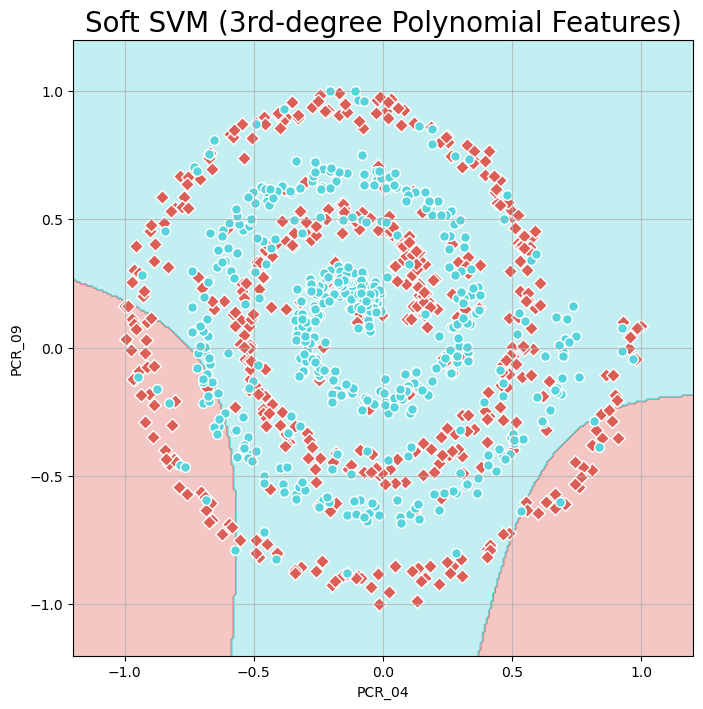

Training Accuracy: 53.70%


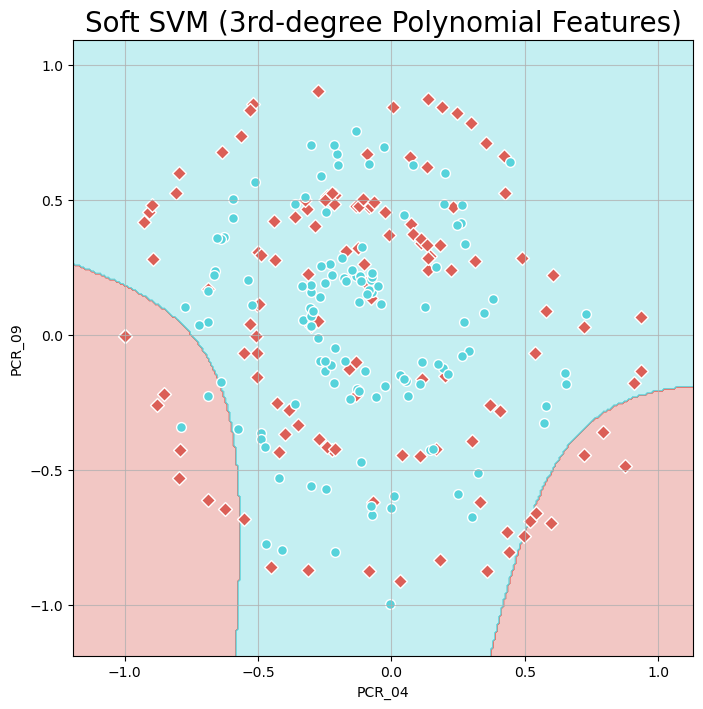

Test Accuracy: 55.2%


In [409]:
# Complete  the  pipeline  above  to  make  it  apply  a  3rd-degree  PolynomialFeatures 
# transformation. Use the learning rate you chose in (Q11). Train the model. 
# Plot the trained model’s decision regions.

from sklearn.pipeline import Pipeline 
svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),  
('scaler', MinMaxScaler()),  
('SVM', SoftSVM(C=1e5, lr=1e-07))]) 
svm_clf.fit(X_train.to_numpy(), y_train.to_numpy())

# Plot the decision regions of the trained model
visualize_clf(svm_clf, X_train, y_train, 'Soft SVM (3rd-degree Polynomial Features)', 'PCR_04', 'PCR_09')

# Compute the training and test accuracies
train_score = svm_clf.score(X_train.to_numpy(), y_train.to_numpy())
print(f'Training Accuracy: {train_score * 100:.2f}%')

# Test later the difference between score and predict ##############################################
test_score = svm_clf.predict(test_df[['PCR_04', 'PCR_09']].to_numpy())
test_accuracy = np.mean(test_score == test_df['spread'])
visualize_clf(svm_clf, test_df[['PCR_04', 'PCR_09']], test_df['spread'], 'Soft SVM (3rd-degree Polynomial Features)', 'PCR_04', 'PCR_09')
print(f'Test Accuracy: {test_accuracy * 100}%')



***Part 4: The RBF kernel***

In [ ]:
X_svm_test = test_df[['PCR_04', 'PCR_09']]
y_svm_test = test_df['spread']

In [ ]:
# (Q14) Use sklearn.svm.SVC to train an SVM with an RBF kernel on the two features and the 
# spread variable, with C=1 and 𝛾 =1e-7. Plot the model’s decision regions and include 
# this  plot  in  your  report.  Additionally,  provide  the  training  and  test  accuracies  of  the 
# model.  Based  on  these  accuracies,  would  you  classify  the  model  as  underfitting, 
# overfitting, or as a reasonable fit?

from sklearn.svm import SVC

# Create the SVM model with RBF kernel and specified hyperparameters
svm_model = SVC(C=1, gamma=1e-7, kernel='rbf')

# Fit the model to the training data
svm_model.fit(X_svm, y_svm)

# Plot the decision regions of the trained model
visualize_clf(svm_model, X_svm, y_svm, 'SVM with RBF Kernel', 'PCR_04', 'PCR_09')

# Get the training and test accuracies of the model
train_accuracy = svm_model.score(X_svm, y_svm)
test_accuracy  = svm_model.score(X_svm_test, y_svm_test)

# Get the test accuracy of the model (if test data is available)
# test_accuracy = svm_model.score(X_test, y_test)

# Print the training and test accuracies
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
# print(f"Test Accuracy: {test_accuracy}")

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


In [ ]:
# (Q15) Use sklearn.svm.SVC to train an SVM with an RBF kernel on the two features and the 
# spread variable, with C=1 and 𝛾 =200. Plot the model’s decision regions and include 
# this  plot  in  your  report.  Additionally,  provide  the  training  and  test  accuracies  of  the 
# model.  Compare  the  decision  regions  of  this  model  with  the  k-NN  model  with  
# 𝑘 = 1 from (Q1). We expected the two models to be very similar, but we should still see 
# significant differences. Try to explain the differences

# Create the SVM model with RBF kernel and specified hyperparameters
svm_model = SVC(C=1, gamma=200, kernel='rbf')

# Fit the model to the training data
svm_model.fit(X_svm, y_svm)

# Plot the decision regions of the trained model
visualize_clf(svm_model, X_svm, y_svm, 'SVM with RBF Kernel', 'PCR_04', 'PCR_09')

# Get the training and test accuracies of the model
train_accuracy = svm_model.score(X_svm, y_svm)
test_accuracy  = svm_model.score(X_svm_test, y_svm_test)

# Get the test accuracy of the model (if test data is available)
# test_accuracy = svm_model.score(X_test, y_test)

# Print the training and test accuracies
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
# print(f"Test Accuracy: {test_accuracy}")

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


In [ ]:
from sklearn.svm import SVC

# (Q16) Use sklearn.svm.SVC to train an SVM with an RBF kernel on the two features and the 
# spread variable, with C=1 and 𝛾 = 5000. Plot the model’s decision regions and include 
# this plot in your report. Additionally, provide the training and test accuracies of the 
# model. Based on these accuracies, would you classify the model as underfitting, 
# overfitting, or as a reasonable fit?


# Create the SVM model with RBF kernel and specified hyperparameters
svm_model = SVC(C=1, gamma=5000, kernel='rbf')

# Fit the model to the training data
svm_model.fit(X_svm, y_svm)

# Plot the decision regions of the trained model
visualize_clf(svm_model, X_svm, y_svm, 'SVM with RBF Kernel', 'PCR_04', 'PCR_09')

# Get the training and test accuracies of the model
train_accuracy = svm_model.score(X_svm, y_svm)
test_accuracy  = svm_model.score(X_svm_test, y_svm_test)

# Print the training and test accuracies
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
